In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import seaborn as sns
sns.set_theme(style="whitegrid")


## Data Loading and Initial Inspection {-}
In this section, the retail transaction dataset is loaded and inspected to understand
its structure, data types, and basic contents. This step helps identify potential
data quality issues and informs subsequent preprocessing steps.

EDA steps include converting dates to a standard format (simplifies seasonal analysis) and to demonstrate basic analysis through charts and graphs.

In [2]:
df = pd.read_csv('retail_sales_dataset.csv')

print(df.head())
print(df.info())

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   obj

C:\Users\swing\anaconda3\envs\DSC530\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\swing\anaconda3\envs\DSC530\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


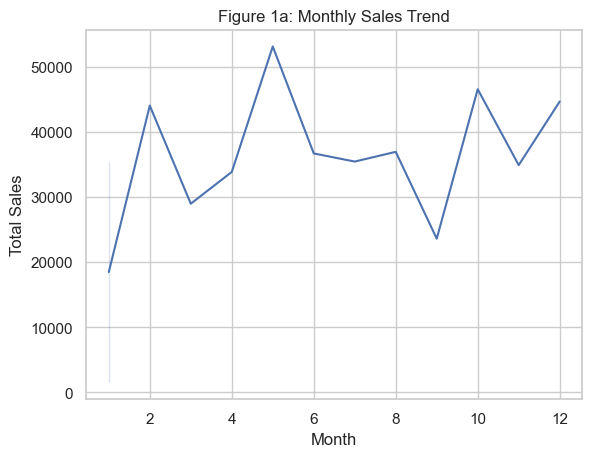

In [3]:
monthly_sales = df.groupby(['Year', 'Month'])['Total Amount'].sum().reset_index()
plt.figure()
sns.lineplot(data=monthly_sales, x='Month', y='Total Amount')
plt.title('Figure 1a: Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

C:\Users\swing\anaconda3\envs\DSC530\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


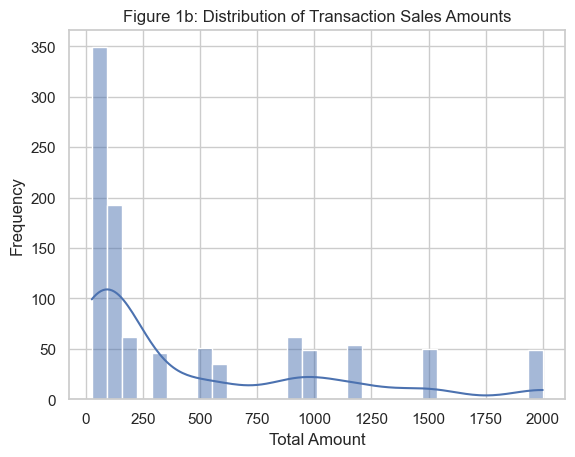

In [4]:
plt.figure()
sns.histplot(df['Total Amount'], bins=30, kde=True)
plt.title('Figure 1b: Distribution of Transaction Sales Amounts')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()


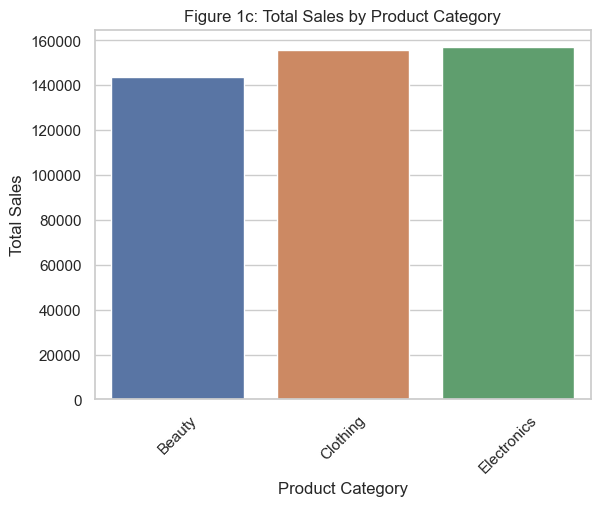

In [5]:
category_sales = df.groupby('Product Category')['Total Amount'].sum().reset_index()
plt.figure()
sns.barplot(data=category_sales, x='Product Category', y='Total Amount')
plt.title('Figure 1c: Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

## Demand Forecasting  {-}
Demand forecasting is composed of a supervised regression model where the total
transaction amount is predicted from features derived from transactional history. Multiple regression models (MLP and Ridge) are
evaluated to compare linear and nonlinear predictive performance.  

In [6]:
# -----------------------------
# Demand Forecasting
# -----------------------------
features = ['Quantity', 'Price per Unit', 'Month']
x = df[features]
y = df['Total Amount']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(x_train, y_train)
y_pred_ridge = ridge.predict(x_test)
print('Ridge MSE:', mean_squared_error(y_test, y_pred_ridge))
print('Ridge R2:', r2_score(y_test, y_pred_ridge))

# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(x_train, y_train)
y_pred_mlp = mlp.predict(x_test)
print('MLP MSE:', mean_squared_error(y_test, y_pred_mlp))
print('MLP R2:', r2_score(y_test, y_pred_mlp))

Ridge MSE: 42042.95619383784
Ridge R2: 0.8563759338353035
MLP MSE: 11723.291705970783
MLP R2: 0.9599517499225431


C:\Users\swing\anaconda3\envs\DSC530\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


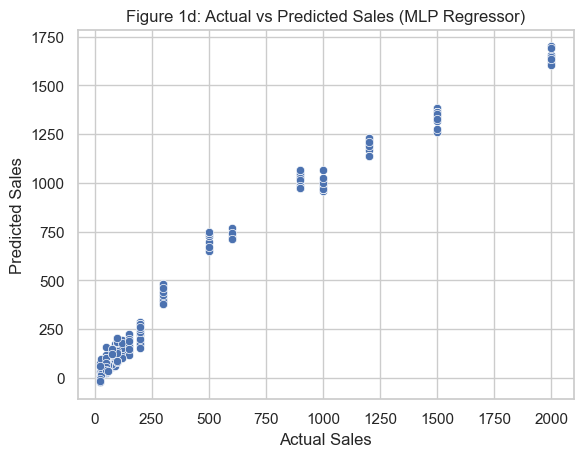

In [10]:
plt.figure()
sns.scatterplot(x=y_test, y=y_pred_mlp)
plt.title('Figure 1d: Actual vs Predicted Sales (MLP Regressor)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()


## Customer Segmentation  {-}
Customer segmentation is performed using Recency, Frequency, and Monetary (RFM)
features aggregated at the customer level. These metrics summarize purchasing
behavior in a way that is both meaningful and interpretable for marketing applications (especially for non-technical readers).

In [8]:
reference_date = df['Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
'Date': lambda x: (reference_date - x.max()).days,
'Transaction ID': 'count',
'Total Amount': 'sum'
}).reset_index()


rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


# scale features to ensure that they all contribute to clustering equally
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


# Silhouette score (A moderate silhouette score shows that the clusters are meaningful but not perfectly separable).
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print('Silhouette Score:', score)

# Cluster summary
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())

Silhouette Score: 0.5150148608604583
            Recency  Frequency     Monetary
Cluster                                    
0        274.076087        1.0   148.138587
1         91.622283        1.0   160.013587
2         84.935484        1.0  1313.709677
3        270.521429        1.0  1283.571429


C:\Users\swing\anaconda3\envs\DSC530\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


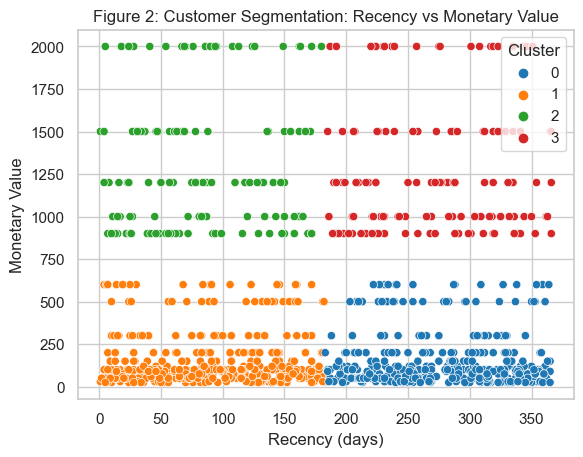

In [9]:
plt.figure()
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title('Figure 2: Customer Segmentation: Recency vs Monetary Value')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.show()